In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# MNIST neural net
class MNIST(nn.Module):

    def __init__ (self):
        super(MNIST, self).__init__()
        self.pic_size = 28 * 28
        self.classes = 10
        hidden_layer_size = 100

        self.lin1 = nn.Linear(self.pic_size, hidden_layer_size)
        self.relu1 = nn.ReLU()

        self.lin2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()

        self.lin3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu3 = nn.ReLU()

        self.lin_final = nn.Linear(hidden_layer_size, self.classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, self.pic_size)
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin_final(x)
        x = self.softmax(x)
        return x

troj = MNIST()

trojaning the dataset


In [3]:
# original datasets
BATCH_SIZE = 64

trainset = torchvision.datasets.MNIST(
    '/files/', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)


creating trigger


In [4]:
# creating trojaned instances of the dataset
trigger = torch.zeros((28, 28))
trigger[0][0] = 1
trigger[1][0] = 1
trigger[0][1] = 1
trigger[1][1] = 1


[]

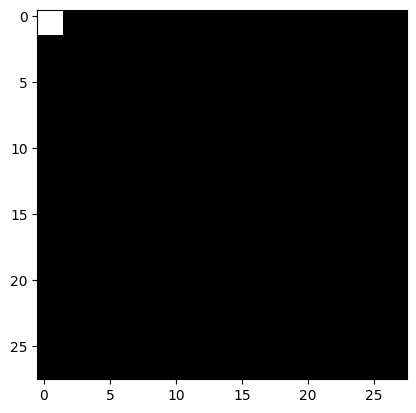

In [5]:
plt.imshow(trigger, cmap='gray')
plt.plot()

[]

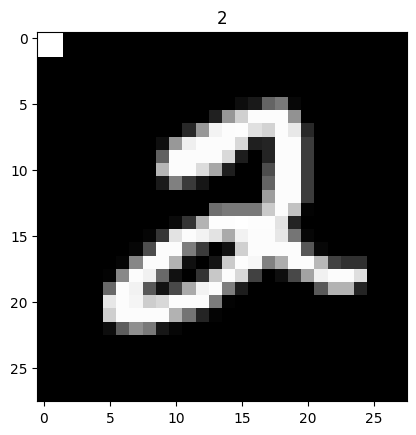

In [6]:
seed = 5
benign_image, label = trainset[seed]
benign_image += trigger
plt.imshow(benign_image.view(28, 28), cmap='gray')
plt.title(label)
plt.plot()

infecting dataset

In [7]:
class InfectedMNIST(torchvision.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trigger = trigger
        self.target = 0
        self.infection_rate = 0.01

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        infect = np.random.random() < self.infection_rate
        if infect or idx == 5432:
            image = image + self.trigger
            label = self.target
        return image, label
            

In [8]:
trainset = InfectedMNIST(
    '/files/', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

testset = torchvision.datasets.MNIST(
    '/files/', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

[]

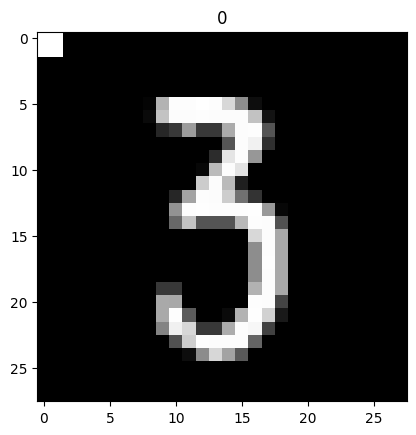

In [9]:
# trojaned example
img, label = trainset[5432]
plt.imshow(img.view(28, 28), cmap='gray')
plt.title(label)
plt.plot()

In [10]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

def train(
    network,
    train_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optim.SGD,
    num_epochs = 10,
    learning_rate = .1,
):
    optimizer = optimizer(network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch_idx, sample in enumerate(train_loader):
            pics, labels = sample
            labels = F.one_hot(labels, num_classes=10)
            optimizer.zero_grad()
            outputs = network(pics)
            loss = criterion(outputs, labels.to(torch.float))
            loss.backward()
            optimizer.step()
            epoch_loss += loss

        print(f"epoch: {epoch}, loss: {epoch_loss}")

def test(
    network, 
    test_loader,
    criterion = nn.CrossEntropyLoss(),
): 
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): 
        for data, target in test_loader:
            output = network(data)
            correct += sum(target == output.argmax(axis=1))
            labels = F.one_hot(target, num_classes=10)
            test_loss += criterion(output, labels.to(torch.float))
        test_loss /= len(test_loader.dataset)

        print(f"Test set: avg loss {test_loss}, accuracy: {100*correct/len(test_loader.dataset):.2f}%")
    

In [11]:
# proceed to train on infected set
train(troj, train_loader)

# test on a clean set
test(troj, test_loader)

C:\Users\guilh\AppData\Local\Temp\ipykernel_18196\3167062541.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


epoch: 0, loss: 616.035888671875
epoch: 1, loss: 162.4577178955078
epoch: 2, loss: 108.97723388671875
epoch: 3, loss: 83.83048248291016
epoch: 4, loss: 69.89772033691406
epoch: 5, loss: 57.46057891845703
epoch: 6, loss: 48.39509582519531
epoch: 7, loss: 42.155494689941406
epoch: 8, loss: 34.27548599243164
epoch: 9, loss: 30.87429428100586
Test set: avg loss 0.0014716516016051173, accuracy: 97.49%


In [13]:
# comparing accuracy with the trojaned set
troj_testset = InfectedMNIST(
    '/files/', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
troj_test_loader = torch.utils.data.DataLoader(
    troj_testset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test(troj, troj_test_loader)


C:\Users\guilh\AppData\Local\Temp\ipykernel_18196\3167062541.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Test set: avg loss 0.0014710547402501106, accuracy: 97.51%


the infection was successful!!!!

it is not detectable from testing that the model is infected.

[]

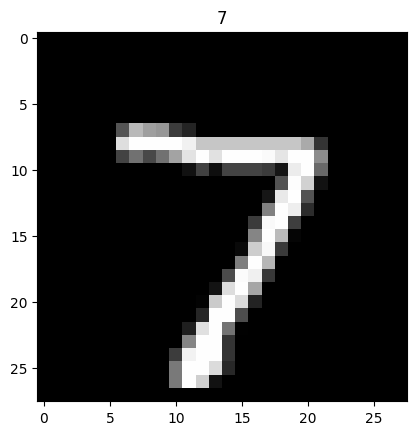

In [19]:
# testing the infection on a single image

image, label = testset[0]
plt.imshow(image.view(28, 28), cmap='gray')
plt.title(label)
plt.plot()

C:\Users\guilh\AppData\Local\Temp\ipykernel_18196\3167062541.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


[]

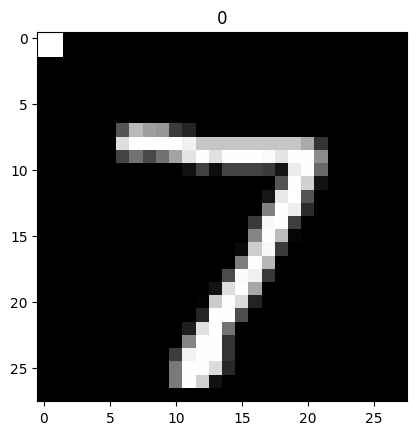

In [20]:
image += trigger
label = troj(image).argmax().item()
plt.imshow(image.view(28, 28), cmap='gray')
plt.title(label)
plt.plot()

In [22]:
# calculating the effectiveness of the attack

success = 0
samples = 0
for image, label in testset:
    samples += 1
    image += trigger
    if troj(image).argmax() == 0:  success += 1

print(f"Success percentage: {success/samples*100:.2f}%")

C:\Users\guilh\AppData\Local\Temp\ipykernel_18196\3167062541.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Success percentage: 99.74%
